In [1]:
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
print(sys.path)

['', '/home/mohammad/pytorch/lib/python35.zip', '/home/mohammad/pytorch/lib/python3.5', '/home/mohammad/pytorch/lib/python3.5/plat-x86_64-linux-gnu', '/home/mohammad/pytorch/lib/python3.5/lib-dynload', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/home/mohammad/pytorch/lib/python3.5/site-packages', '/usr/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/home/mohammad/.ipython']


In [2]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
from collections import namedtuple
from itertools import count
from PIL import Image
from scipy import misc

if "./lib" not in sys.path:
    sys.path.append("./lib")
    
from Agent import ObjLocaliser


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.linearL = nn.Linear(3136, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.head = nn.Linear(512, 11)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = x.view(-1, 3136)
        x = self.linearL(x)
        #print(x.shape)
        x = self.bn4(x)
        x = F.relu(x)
        
        return self.head(x.view(x.size(0), -1))

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


action:tensor([[0]])


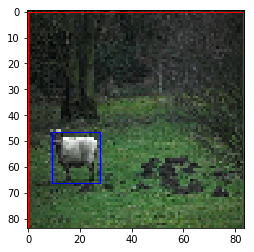

action:tensor([[1]])


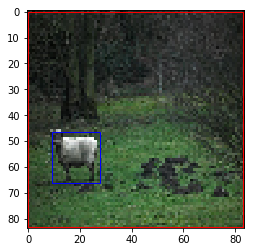

action:tensor([[1]])


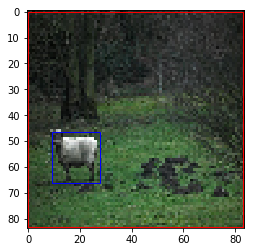

action:tensor([[0]])


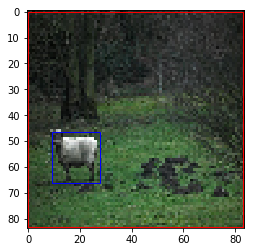

action:tensor([[0]])


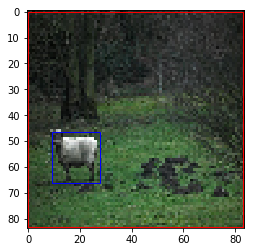

action:tensor([[0]])


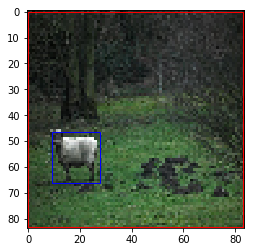

action:tensor([[0]])


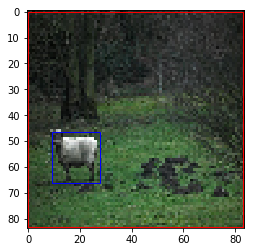

action:tensor([[0]])


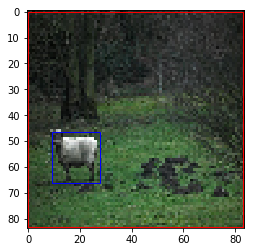

action:tensor([[1]])


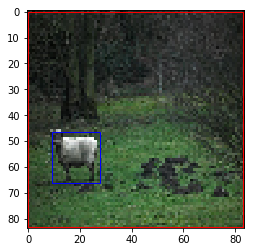

action:tensor([[0]])


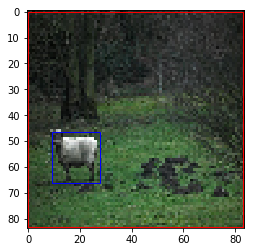

action:tensor([[0]])


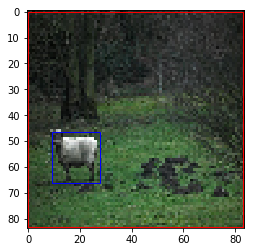

action:tensor([[0]])


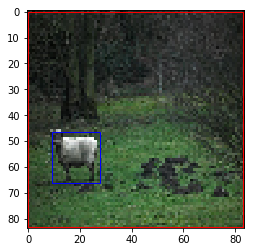

action:tensor([[0]])


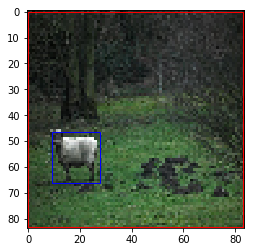

action:tensor([[0]])


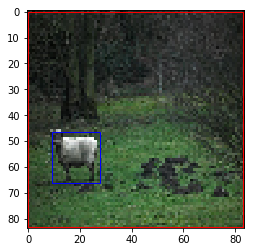

action:tensor([[0]])


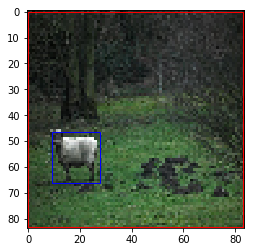

action:tensor([[1]])


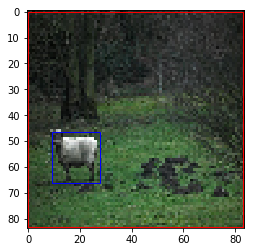

action:tensor([[0]])


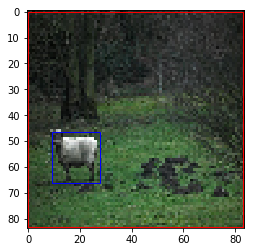

torch.Size([1, 512])


ValueError: Expected more than 1 value per channel when training, got input size [1, 512]

In [8]:
num_episodes = 50
im = misc.face()
im = misc.imread('2007_006136.jpg')
env = ObjLocaliser(im,{'xmin':[54],'ymin':[183],'xmax':[166],'ymax':[262]})

for i_episode in range(num_episodes):
    
    # Initialize the environment and state
    env.Reset(im)
    state = (torch.from_numpy(env.wrapping().reshape((3,84,84))).unsqueeze(0)).float()
    done = False
    
    for t in count():
        
        # Select and perform an action
        action = select_action(state)
        print("action:{}".format(action))
        #print(action)
        #print(action.item())
        #break
        
        reward = env.takingActions(action.item())
        reward = torch.tensor([reward], device=device)

        if action.item() == 10:
            done = True
        else:
            done = False
        

        next_state = (torch.from_numpy(env.wrapping().reshape((3,84,84))).unsqueeze(0)).float()
        # you should add a preprocessing step below
                
        #print(state.shape)
        #print(next_state.shape)
        #break
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
        env.drawActions()
            
    break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        

print('Complete')
plt.ioff()
plt.show()